In [ ]:
#Makes time series graphs for precipitation metrics


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import stats
from geopy.distance import great_circle
from scipy.stats.stats import pearsonr

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/rphinney/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:

station = 'USW00014935'   

#change to file on shiva?
filename = '/Users/rphinney/Documents/Hollings/ghcnd_all/'+station+'.dly'
file = open(filename, 'r')


 GRAND ISLAND AP              


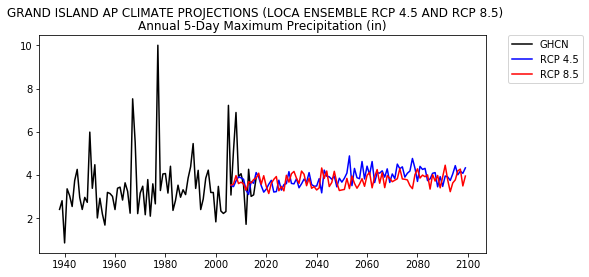

In [9]:

    
#Using ghcnd-stations.txt get the station information

#change to file on shiva?
path = '/Users/rphinney/Documents/Hollings/ghcnd-stations.txt'

station_file = open(path)
ghcnd = []

for x in station_file:
    ghcnd.append(x)

for each_line in ghcnd:   
    if each_line[0:11] == station:
        station_name = each_line[40:70]
        station_state = each_line[38:40]
        latitude = each_line[13:20]
        longitude = each_line[21:31]
        elevation = each_line[32:38]
        station_name.strip()
        print(station_name)
            
                      
#------------------------------------------------------------------
#Open the LOCA ensemble file and match the station to the nearest grid


file45 = '/Users/rphinney/Documents/Hollings/prmax5day/rcp45/ensemble.nc'
file85 = '/Users/rphinney/Documents/Hollings/prmax5day/rcp85/ensemble.nc'

data45 = Dataset(file45)
data85 = Dataset(file85)
    
lon = data45.variables['lon'][:]
lat = data45.variables['lat'][:]
prcp = data45.variables['prmax5day'][:]
prcp2 = data85.variables['prmax5day'][:]

            
station_loc = (latitude,longitude)
min_loc = 9999
    
for lons in lon:
    for lats in lat:
        check_loc = (lats,lons)
        b = int(great_circle(station_loc,check_loc).miles)
        if b < min_loc:
            min_loc = b
            min_lat = lats
            min_lon = lons-360

#y = np.arange(1950,2014)           
prcpa = []
prcpb = []
lon_count = -1
lat_count = -1
for lons in lon:
    lon_count = lon_count +1
    if lons == min_lon+360:
        for lats in lat:
            lat_count = lat_count + 1
            if lats == min_lat:
                for x in range (0,94):
                    prcp45 = .03937*prcp[x,lat_count,lon_count]
                    prcpa.append(prcp45)
                    prcp85 = .03937*prcp2[x,lat_count,lon_count]
                    prcpb.append(prcp85)
    


#---------------------------------------------------------------------------
#find the annual max 1 day precip from the GHCN station


begin_year = 1950
end_year = 2013

mylist = []
five_max = []

for line in file:
    mylist.append(line)
    
#find the beginning year of the file
for first in mylist:
    if first[17:21] == "PRCP":
        min_year = int(first[11:15])
        break
max_year = 2017

daymax = []
all_prcp = []
for year in range(min_year,max_year):
    year_prcp = []
    for line in mylist:
        if int(line[11:15]) == year:
            if line[17:21] == 'PRCP':
                year_prcp.append(line)

    new_prcp = []
    trace = []
    for data in year_prcp:
        char1 = 22
        char2 = 26
        while char1 != 270:
            if data[char1:char2] == '9999':
                char1 = char1 + 8
                char2 = char2 + 8
            else:
                prcp = (.003937*int(data[char1:char2])) 
                new_prcp.append(prcp)
                char1 = char1 + 8
                char2 = char2 + 8
                    
    #Get the maximum one-day precip value------------------------------------------
    day_max = max(new_prcp, default = 0)
    daymax.append(day_max)
    
    #Get the maximum five-day precip value-----------------------------------------
    begin = 0
    end = 5
    max5 = sum(new_prcp[begin:end])
    
    for x in new_prcp:
        begin = begin + 1
        end = end + 1
        b = sum(new_prcp[begin:end])
        max5 = max(b, max5)
    if max5 == 0:
        max5 = -9999
    five_max.append(max5)            


x = np.arange(min_year,2017)


def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

a = np.arange(2006,2100)
plt.figure(figsize(8,4))
plt.plot(x,five_max, color = 'black', label = 'GHCN')
plt.plot(a,prcpb,color = 'blue', label = 'RCP 4.5')
plt.plot(a,prcpa, color = 'red', label = 'RCP 8.5')


plt.title('Annual 5-Day Maximum Precipitation (in)')
plt.suptitle(station_name.strip() + ' CLIMATE PROJECTIONS (LOCA ENSEMBLE RCP 4.5 AND RCP 8.5)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#savefig()